In [50]:
import os
os.chdir('/Users/richb/Desktop/COHP_toydata/jdftx_mod_test')
import numpy as np
import funcs as func
bandfile='water.bandProjections'
gvecfile='water.Gvectors'
eigfile='water.eigenvals'
proj, nStates, nBands, nProj, nSpecies, nOrbsPerAtom = func.parse_bandfile(bandfile)
wk, iGarr, k_points, nStates = func.parse_gvecfile(gvecfile)
E = func.parse_eigfile(eigfile, nStates)
def T_ijk(iorb, jband, kstate):
	return proj[kstate][jband][iorb]
def P_uvjk(uorb,vorb,jband, kstate):
	return np.conjugate(T_ijk(uorb, jband, kstate))*T_ijk(vorb, jband, kstate)
def e_jk(jband,kstate):
	return E[kstate][jband]
def H_uvk(uorb,vorb,kstate):
	sum_hold = 0
	for j in range(nBands):
		sum_hold += e_jk(j, kstate)*P_uvjk(uorb, vorb, j, kstate)
	return sum_hold
def pCOHP_uvk(uorb,vorb,kstate,Emin,Emax,dE):
	Huvk = H_uvk(uorb,vorb,kstate)
	Egrid = np.arange(Emin, Emax + dE, dE)
	output = np.zeros(np.shape(Egrid))
	for j in range(nBands):
		ejk = e_jk(j, kstate)
		if ((ejk < Emax) and (ejk > Emin)):
			e_idx = int(np.floor((ejk - Emin)/dE))
			e_weight = ejk - Egrid[e_idx]
			e_spill = Egrid[int(e_idx + 1)] - ejk
			x = P_uvjk(uorb, vorb, j, kstate) * Huvk
			output[e_idx] += np.real(x) * e_weight
			output[e_idx+1] += np.real(x) * e_spill
	return output, Egrid
def pCOHP_uv(uorb,vorb,Emin,Emax,dE):
	Egrid = np.arange(Emin, Emax + dE, dE)
	output = np.zeros(np.shape(Egrid))
	for k in range(nStates):
		output += pCOHP_uvk(uorb,vorb,k,Emin,Emax,dE)[0] * wk[k]
	return output, Egrid

In [46]:
wk

[0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25]

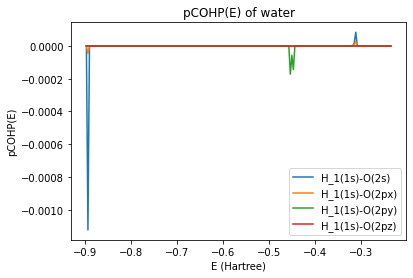

In [60]:
import matplotlib.pyplot as plt
pts = 200
minE = np.min(E)
maxE = np.max(E)
dE = (maxE - minE)/pts
pCOHP_02, Egrid = pCOHP_uv(0, 2, minE, maxE, dE)
pCOHP_03, Egrid = pCOHP_uv(0, 3, minE, maxE, dE)
pCOHP_04, Egrid = pCOHP_uv(0, 4, minE, maxE, dE)
pCOHP_05, Egrid = pCOHP_uv(0, 5, minE, maxE, dE)
pCOHP_12, Egrid = pCOHP_uv(1, 2, minE, maxE, dE)
pCOHP_13, Egrid = pCOHP_uv(1, 3, minE, maxE, dE)
pCOHP_14, Egrid = pCOHP_uv(1, 4, minE, maxE, dE)
pCOHP_15, Egrid = pCOHP_uv(1, 5, minE, maxE, dE)
# plt.plot(Egrid, pCOHP_02, label='H_0(1s)-O(2s)')
# plt.plot(Egrid, pCOHP_03, label='H_0(1s)-O(2px)')
# plt.plot(Egrid, pCOHP_04, label='H_0(1s)-O(2py)')
# plt.plot(Egrid, pCOHP_05, label='H_0(1s)-O(2pz)')
plt.plot(Egrid, pCOHP_12, label='H_1(1s)-O(2s)')
plt.plot(Egrid, pCOHP_13, label='H_1(1s)-O(2px)')
plt.plot(Egrid, pCOHP_14, label='H_1(1s)-O(2py)')
plt.plot(Egrid, pCOHP_15, label='H_1(1s)-O(2pz)')
plt.title('pCOHP(E) of water')
plt.xlabel('E (Hartree)')
plt.ylabel('pCOHP(E)')
plt.legend()
plt.savefig('third_of_many.png', bbox_inches='tight', facecolor='white')

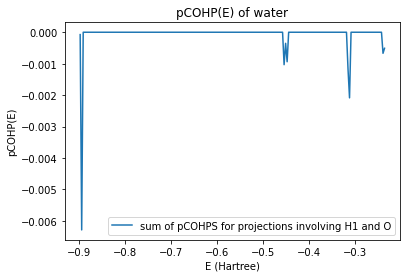

In [62]:
import matplotlib.pyplot as plt
pts = 200
minE = np.min(E)
maxE = np.max(E)
dE = (maxE - minE)/pts
Egrid = np.arange(minE, maxE + dE, dE)
#orb_idcs = H1(1s),O(2s),O(px),O(py),O(pz)
orb_idcs = [1,2,3,4,5]
pCOHP_sum = np.zeros(np.shape(Egrid))
for u in orb_idcs:
	for v in orb_idcs:
		pCOHP_sum += pCOHP_uv(u, v, minE, maxE, dE)[0]

plt.plot(Egrid, pCOHP_sum, label=r'$\sum_{\mu,\nu}ppCOHP_{}$')
plt.title('pCOHP(E) of water')
plt.xlabel('E (Hartree)')
plt.ylabel('pCOHP(E)')
plt.legend()
plt.savefig('ppCOHP_sum.png', bbox_inches='tight', facecolor='white')

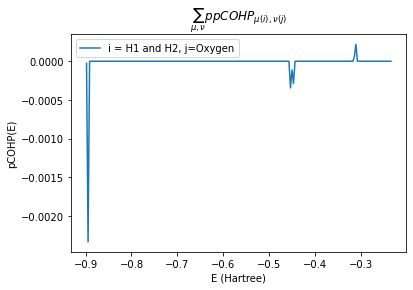

In [70]:
import matplotlib.pyplot as plt
pts = 200
minE = np.min(E)
maxE = np.max(E)
dE = (maxE - minE)/pts
Egrid = np.arange(minE, maxE + dE, dE)
#orb_idcs = H1(1s),O(2s),O(px),O(py),O(pz)
orb_idcs = [1,2,3,4,5]
H_orb_idcs = [0, 1]
Ox_orb_idcs = [2,3,4,5]
pCOHP_sum = np.zeros(np.shape(Egrid))
for u in H_orb_idcs:
	for v in Ox_orb_idcs:
		pCOHP_sum += pCOHP_uv(u, v, minE, maxE, dE)[0]

plt.plot(Egrid, pCOHP_sum, label='i = H1 and H2, j=Oxygen')
plt.title(r'$\sum_{\mu,\nu}ppCOHP_{\mu(i),\nu(j)}$')
plt.xlabel('E (Hartree)')
plt.ylabel('pCOHP(E)')
plt.legend()
plt.savefig('ppCOHP_sum_by_atom.png', bbox_inches='tight', facecolor='white')

In [37]:
testval = 0.45
testout = int(np.floor((testval - tmin)/tdE))

In [36]:
testout

3.0

In [48]:
nStates

8

In [71]:
os.chdir('/Users/richb/Documents/water_bench')

In [77]:
chk_file = np.fromfile('water.fchk', dtype=str)

ValueError: negative dimensions are not allowed

In [81]:
import re

# Open the fchk file
with open('water.fchk', 'r') as f:
    data = f.read()

# Find the start and end indices of the ClPar Real Params section
start_index = data.find('ClPar Real Params')
end_index = data.find('Variables:')

# Extract the ClPar Real Params section as a string
clpar_section = data[start_index:end_index]

# Split the section into individual lines
clpar_lines = clpar_section.strip().split('\n')

# Parse the lines to extract the relevant data for each basis function
basis_functions = []
for i in range(1, len(clpar_lines)):
    line = clpar_lines[i]
    fields = re.split('\s+', line.strip())
    print(fields)
    coords = [float(fields[0]), float(fields[1]), float(fields[2])]
    lmn = [int(float(fields[3])), int(float(fields[4])), int(float(fields[5]))]
    norm = float(fields[6])
    alpha = float(fields[7])
    basis_functions.append({'coords': coords, 'lmn': lmn, 'norm': norm, 'alpha': alpha})

# Print the parsed data
for bf in basis_functions:
    print('Coords:', bf['coords'])
    print('LMN:', bf['lmn'])
    print('Normalization:', bf['norm'])
    print('Exponent:', bf['alpha'])

['0.00000000E+00', '0.00000000E+00', '0.00000000E+00', '0.00000000E+00', '0.00000000E+00']


IndexError: list index out of range